# Exploring Dandiset 001333: Parkinson's Electrophysiological Signal Dataset (PESD)

## Disclaimer

**IMPORTANT: This notebook was AI-generated and has not been fully verified. Please be cautious when interpreting the code or results.**

## Overview

This notebook explores the Parkinson's Electrophysiological Signal Dataset (PESD), which contains electrophysiological signals from both healthy and parkinsonian subjects. The dataset is available on the DANDI Archive at [https://dandiarchive.org/dandiset/001333/0.250327.2220](https://dandiarchive.org/dandiset/001333/0.250327.2220).

The dataset contains two main types of electrophysiological signals:

1. **Beta Average Rectified Voltage (ARV)**: These signals are in the frequency domain and represent the average rectified value of the beta band, which is calculated by rectifying the filtered Local Field Potential (LFP) signal.

2. **Local Field Potentials (LFP)**: These signals are in the time domain and are derived from the synchronized activity of neuron populations between the cortex, subthalamic nucleus (STN), and thalamus.

In Parkinson's disease, beta oscillations (13-30 Hz) in the subthalamic nucleus are typically used as pathological biomarkers for PD symptoms.

This notebook will:

1. Load the dataset using the DANDI API
2. Explore the metadata and structure of the NWB files
3. Visualize both LFP and Beta ARV data
4. Compare differences between these signal types
5. Analyze features that might be relevant to Parkinson's disease research

## Required Packages

This notebook requires several packages:
- `pynwb` - For working with Neurodata Without Borders (NWB) files
- `h5py` - For working with the HDF5 file format that NWB uses
- `remfile` - For streaming remote files
- `numpy` - For numerical operations
- `matplotlib` - For visualization
- `pandas` - For data manipulation
- `scipy` - For signal processing

In [1]:
# Import necessary packages
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import seaborn as sns
from itertools import islice

# Set plotting style
sns.set_theme()

## Loading the Dandiset using DANDI API

First, we'll connect to the DANDI archive and retrieve basic information about the Dandiset.

In [2]:
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001333", "0.250327.2220")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

# List some assets in the Dandiset
assets = dandiset.get_assets()
print("\nFirst 5 assets:")
for asset in islice(assets, 5):
    print(f"- {asset.path} (ID: {asset.identifier})")

Dandiset name: Parkinson's Electrophysiological Signal Dataset (PESD)
Dandiset URL: https://dandiarchive.org/dandiset/001333/0.250327.2220

First 5 assets:
- sub-healthy-simulated-data/sub-healthy-simulated-data_ses-001_ecephys.nwb (ID: 5409700b-e080-44e6-a6db-1d3e8890cd6c)
- sub-healthy-simulated-beta/sub-healthy-simulated-beta_ses-218_ecephys.nwb (ID: da77917e-655c-4eeb-a0a6-7529a8a35901)
- sub-healthy-simulated-beta/sub-healthy-simulated-beta_ses-279_ecephys.nwb (ID: aa743a96-e79b-40b1-a0df-55ef3460e856)
- sub-healthy-simulated-beta/sub-healthy-simulated-beta_ses-423_ecephys.nwb (ID: 068afe41-3b8e-402f-91d4-9f297df677a2)
- sub-healthy-simulated-beta/sub-healthy-simulated-beta_ses-162_ecephys.nwb (ID: b344c8b7-422f-46bb-b016-b47dc1e87c65)


## Exploring an NWB File with LFP Data

Let's load and explore one of the NWB files containing Local Field Potential (LFP) data. We've selected the file `sub-healthy-simulated-lfp_ses-54_ecephys.nwb` from a healthy simulated subject.

In [3]:
# Load a specific NWB file for LFP data
lfp_url = "https://api.dandiarchive.org/api/assets/3cf468a1-4933-4aa6-b1c3-4a261b3ee6db/download/"
lfp_remote_file = remfile.File(lfp_url)
lfp_h5_file = h5py.File(lfp_remote_file)
lfp_io = pynwb.NWBHDF5IO(file=lfp_h5_file)
lfp_nwb = lfp_io.read()

# Display basic metadata about the NWB file
print(f"NWB File ID: {lfp_nwb.identifier}")
print(f"Session Description: {lfp_nwb.session_description}")
print(f"Session Start Time: {lfp_nwb.session_start_time}")
print(f"Subject ID: {lfp_nwb.subject.subject_id}")
print(f"Keywords: {', '.join(lfp_nwb.keywords[:])}")

NWB File ID: bf19e411-babb-4247-acc1-3bc14e4292fd
Session Description: Parkinson's Electrophysiological Signal Dataset (PESD) Generated from Simulation
Session Start Time: 2025-03-27 16:53:32.931278-04:00
Subject ID: healthy-simulated-lfp
Keywords: ecephys, LFP, Parkinson's Disease, Beta Band


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


You can explore this NWB file interactively on Neurosift: [https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/3cf468a1-4933-4aa6-b1c3-4a261b3ee6db/download/&dandisetId=001333&dandisetVersion=0.250327.2220](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/3cf468a1-4933-4aa6-b1c3-4a261b3ee6db/download/&dandisetId=001333&dandisetVersion=0.250327.2220)

## Structure of the LFP NWB File

Let's examine the structure of the NWB file to understand what data it contains:

In [4]:
# Get information about the electrodes
electrode_df = lfp_nwb.electrodes.to_dataframe()
print("Electrode Information:")
print(electrode_df)

# Get information about the LFP data
lfp_data_interface = lfp_nwb.processing["ecephys"].data_interfaces["LFP"]
lfp_series = lfp_data_interface.electrical_series["LFP"]

print("\nLFP Data Information:")
print(f"Sampling Rate: {lfp_series.rate} Hz")
print(f"Number of Samples: {lfp_series.data.shape[0]}")
print(f"Duration: {lfp_series.data.shape[0] / lfp_series.rate:.2f} seconds")
print(f"Unit: {lfp_series.unit}")

Electrode Information:
                                            location  \
id                                                     
0   Simulated Cortico-basal-ganglia network of brain   
1   Simulated Cortico-basal-ganglia network of brain   
2   Simulated Cortico-basal-ganglia network of brain   
3   Simulated Cortico-basal-ganglia network of brain   
4   Simulated Cortico-basal-ganglia network of brain   
5   Simulated Cortico-basal-ganglia network of brain   
6   Simulated Cortico-basal-ganglia network of brain   
7   Simulated Cortico-basal-ganglia network of brain   
8   Simulated Cortico-basal-ganglia network of brain   
9   Simulated Cortico-basal-ganglia network of brain   
10  Simulated Cortico-basal-ganglia network of brain   
11  Simulated Cortico-basal-ganglia network of brain   

                                                group group_name         label  
id                                                                              
0   shank0 pynwb.ecephys.Elect

The NWB file contains:

- **Electrodes**: 12 electrodes distributed across 4 shanks
- **LFP Data**: A time series sampled at 2000 Hz, lasting approximately 38.7 seconds
- **Processing Module**: Contains processed LFP data
- **Subject Information**: Indicates this is a simulated healthy subject

## Visualizing the LFP Data

Let's visualize a segment of the LFP data from one electrode:

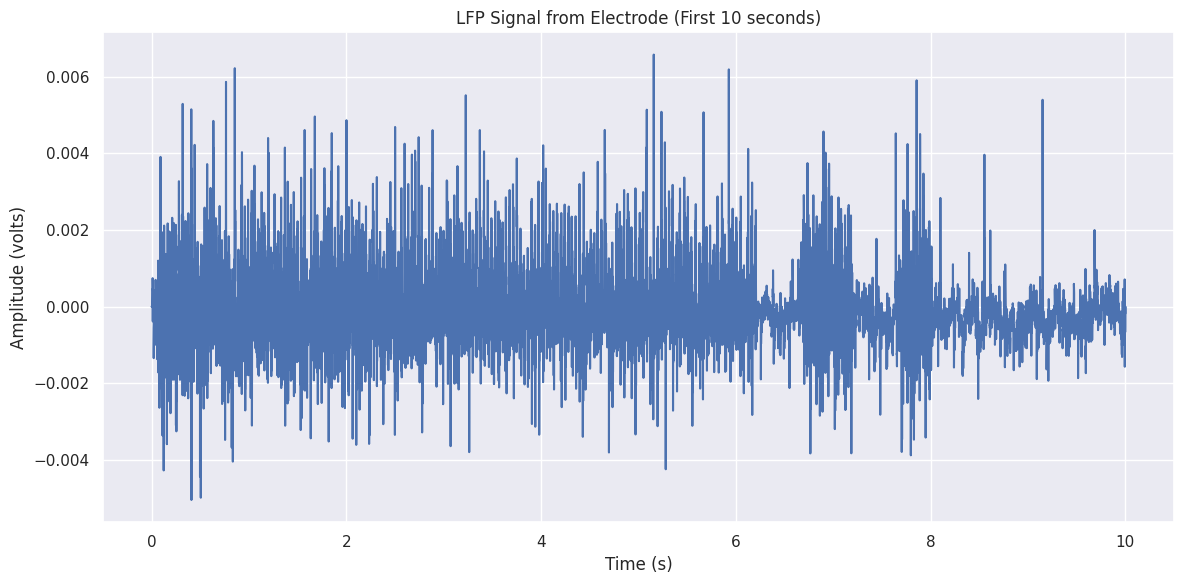

In [5]:
# Load a subset of LFP data (first 10 seconds from first electrode)
seconds_to_plot = 10
samples_to_plot = int(seconds_to_plot * lfp_series.rate)
start_sample = 0

# Get the data
lfp_subset = lfp_series.data[start_sample:start_sample+samples_to_plot]

# Create time array
time = np.arange(samples_to_plot) / lfp_series.rate

# Plot the LFP data
plt.figure(figsize=(12, 6))
plt.plot(time, lfp_subset)
plt.title(f'LFP Signal from Electrode (First {seconds_to_plot} seconds)')
plt.xlabel('Time (s)')
plt.ylabel(f'Amplitude ({lfp_series.unit})')
plt.grid(True)
plt.tight_layout()
plt.show()

Let's plot data from all electrodes to see the variation:

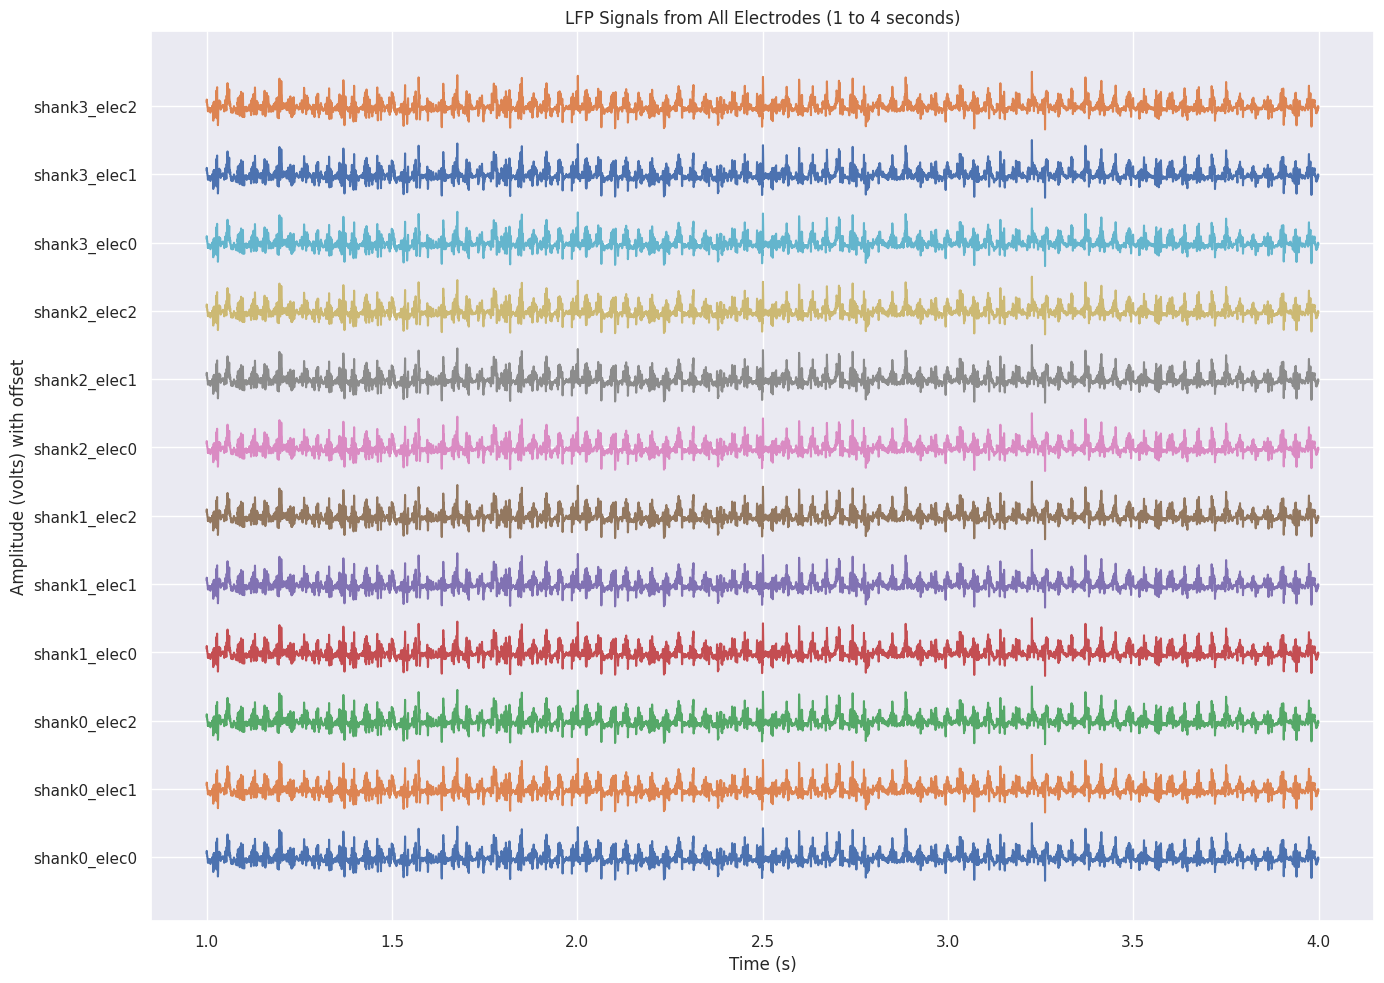

In [6]:
# Get electrode labels
electrode_labels = electrode_df['label'].values

# Define a smaller time range to keep the plot readable
seconds_to_plot = 3
samples_to_plot = int(seconds_to_plot * lfp_series.rate)
start_second = 1 
start_sample = int(start_second * lfp_series.rate)

# Create time array
time = np.arange(samples_to_plot) / lfp_series.rate + start_second

# Plot LFP data from all electrodes
plt.figure(figsize=(14, 10))

# Get data for all electrodes for the specified time range
lfp_subset_all = lfp_series.data[start_sample:start_sample+samples_to_plot]

# Calculate an offset to separate the traces
max_amplitude = np.max(np.abs(lfp_subset_all))
offset = max_amplitude * 2

# Plot each electrode with an offset
for i in range(len(electrode_labels)):
    plt.plot(time, lfp_subset_all + i*offset, label=electrode_labels[i])

plt.title(f'LFP Signals from All Electrodes ({start_second} to {start_second + seconds_to_plot} seconds)')
plt.xlabel('Time (s)')
plt.ylabel(f'Amplitude ({lfp_series.unit}) with offset')
plt.yticks([i*offset for i in range(len(electrode_labels))], electrode_labels)
plt.grid(True)
plt.tight_layout()
plt.show()

## Frequency Domain Analysis of LFP Signal

Now, let's analyze the LFP signal in the frequency domain to see the power spectrum, which will help us identify dominant frequencies, including the beta band (13-30 Hz) that is particularly relevant for Parkinson's disease.

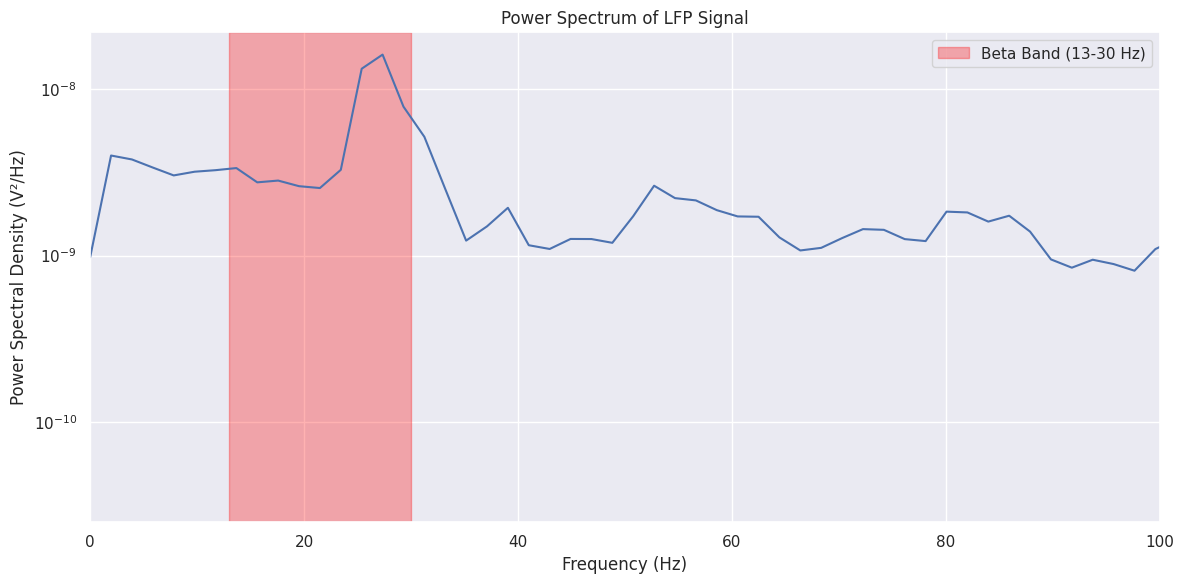

In [7]:
# Select a longer segment for frequency analysis (10 seconds)
seconds_to_analyze = 10
samples_to_analyze = int(seconds_to_analyze * lfp_series.rate)

# Create arrays to store results
electrode_idx = 0  # Choose the first electrode for analysis
lfp_data = lfp_series.data[0:samples_to_analyze]

# Calculate the power spectrum using Welch's method
freq, psd = signal.welch(lfp_data, fs=lfp_series.rate, nperseg=1024)

# Plot the power spectrum
plt.figure(figsize=(12, 6))
plt.semilogy(freq, psd)
plt.title('Power Spectrum of LFP Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')

# Highlight the beta band (13-30 Hz)
plt.axvspan(13, 30, alpha=0.3, color='red', label='Beta Band (13-30 Hz)')
plt.legend()
plt.grid(True)
plt.xlim(0, 100)  # Limit x-axis to 0-100 Hz for better visualization
plt.tight_layout()
plt.show()

## Exploring an NWB File with Beta ARV Data

Now, let's load and explore one of the NWB files containing Beta Average Rectified Voltage (ARV) data from the same subject session.

In [8]:
# Load a specific NWB file for Beta ARV data
beta_url = "https://api.dandiarchive.org/api/assets/73214862-df4b-452b-a35c-d1f3bdb68180/download/"
beta_remote_file = remfile.File(beta_url)
beta_h5_file = h5py.File(beta_remote_file)
beta_io = pynwb.NWBHDF5IO(file=beta_h5_file)
beta_nwb = beta_io.read()

# Display basic metadata about the NWB file
print(f"NWB File ID: {beta_nwb.identifier}")
print(f"Session Description: {beta_nwb.session_description}")
print(f"Subject ID: {beta_nwb.subject.subject_id}")

# Get information about the Beta ARV data
beta_data_interface = beta_nwb.processing["ecephys"].data_interfaces["LFP"]
beta_series = beta_data_interface.electrical_series["Beta_Band_Voltage"]

print("\nBeta ARV Data Information:")
print(f"Number of Timestamps: {beta_series.timestamps.shape[0]}")
print(f"Duration: {beta_series.timestamps[-1] - beta_series.timestamps[0]:.2f} seconds")
print(f"Unit: {beta_series.unit}")

NWB File ID: f62ad0e4-6a25-40b6-847f-a17ce13866ba
Session Description: Parkinson's Electrophysiological Signal Dataset (PESD) Generated from Simulation
Subject ID: healthy-simulated-beta

Beta ARV Data Information:
Number of Timestamps: 1400
Duration: 27.98 seconds
Unit: volts


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


You can explore this NWB file interactively on Neurosift: [https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/73214862-df4b-452b-a35c-d1f3bdb68180/download/&dandisetId=001333&dandisetVersion=0.250327.2220](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/73214862-df4b-452b-a35c-d1f3bdb68180/download/&dandisetId=001333&dandisetVersion=0.250327.2220)

## Structure of the Beta ARV NWB File

The Beta ARV NWB file contains:

- **Electrodes**: Same 12 electrodes as in the LFP file
- **Beta ARV Data**: A time series with 1,400 samples
- **Processing Module**: Contains processed Beta band voltage data
- **Subject Information**: Same simulated healthy subject

## Visualizing the Beta ARV Data

Let's visualize the Beta ARV data:

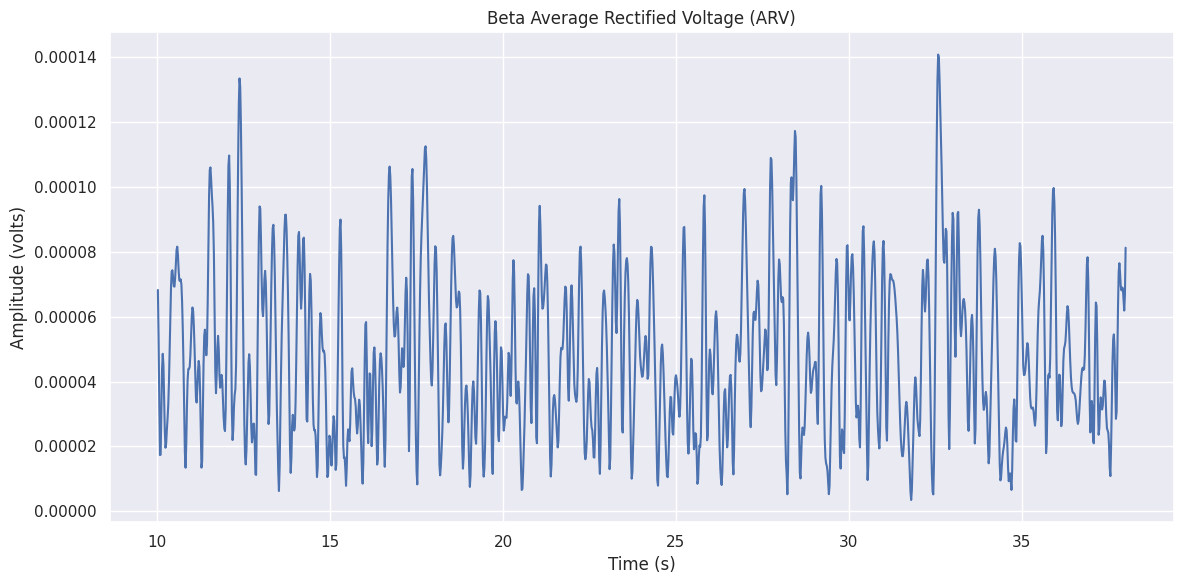

In [9]:
# Get the full Beta ARV data
beta_data = beta_series.data[:]
beta_times = beta_series.timestamps[:]

# Plot the Beta ARV data
plt.figure(figsize=(12, 6))
plt.plot(beta_times, beta_data)
plt.title('Beta Average Rectified Voltage (ARV)')
plt.xlabel('Time (s)')
plt.ylabel(f'Amplitude ({beta_series.unit})')
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparison of LFP and Beta ARV Signals

Let's compare a segment of both signals (LFP and Beta ARV) to understand how they relate:

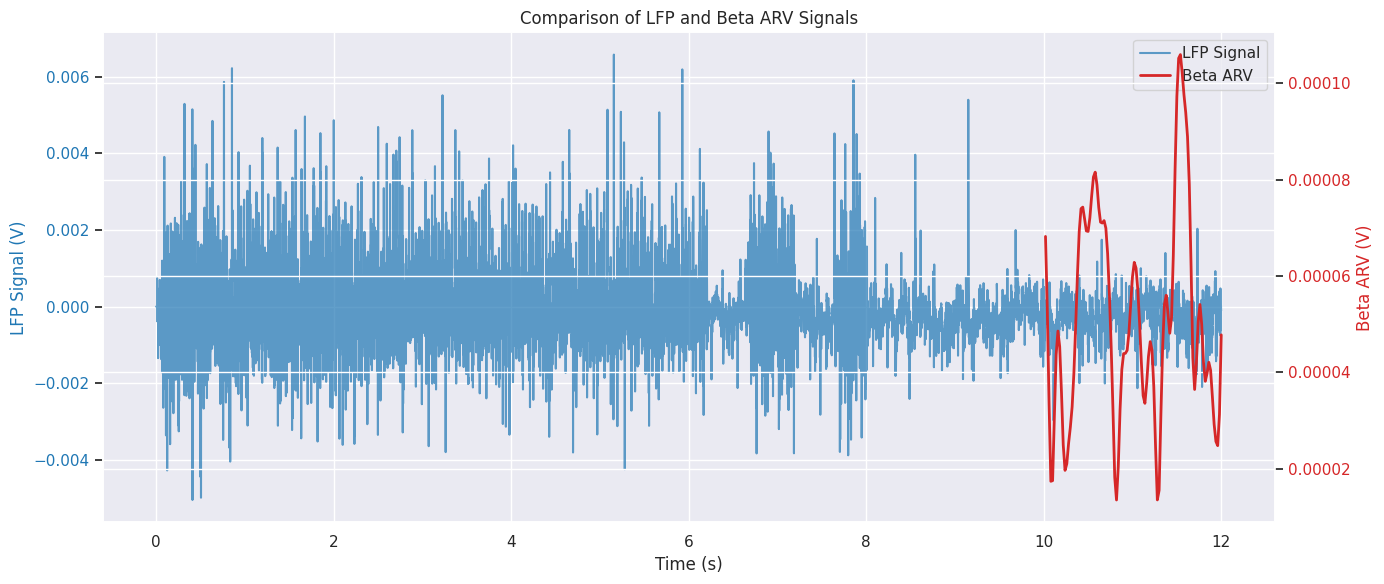

In [10]:
# Determine an appropriate time window based on available data
# For Beta ARV data, let's use the first portion of data
n_samples = 100  # Use the first 100 samples of beta data
beta_subset_times = beta_times[:n_samples]
beta_subset_data = beta_data[:n_samples]
max_beta_time = beta_subset_times[-1]

# For LFP data, use a time range that approximately matches the beta data
lfp_end_sample = int(max_beta_time * lfp_series.rate)
lfp_times = np.arange(lfp_end_sample) / lfp_series.rate
lfp_subset_data = lfp_series.data[:lfp_end_sample]

# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot LFP data on left y-axis
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('LFP Signal (V)', color='tab:blue')
ax1.plot(lfp_times, lfp_subset_data, color='tab:blue', alpha=0.7, label='LFP Signal')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for Beta ARV data
ax2 = ax1.twinx()
ax2.set_ylabel('Beta ARV (V)', color='tab:red')
ax2.plot(beta_subset_times, beta_subset_data, color='tab:red', linewidth=2, label='Beta ARV')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and legend
plt.title('Comparison of LFP and Beta ARV Signals')
fig.tight_layout()

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show()

The above plot shows the relationship between:

1. The raw Local Field Potential (LFP) signal in the time domain (blue)
2. The Beta Average Rectified Voltage (ARV) derived from the LFP signal (red)

The Beta ARV represents the power in the beta frequency band (13-30 Hz) over time, which is used as a biomarker for Parkinson's disease symptoms.

## Analyzing Beta Band Power Over Time

Let's compute the beta band power from the LFP data using a short-time Fourier transform (STFT) and compare it with the provided Beta ARV:

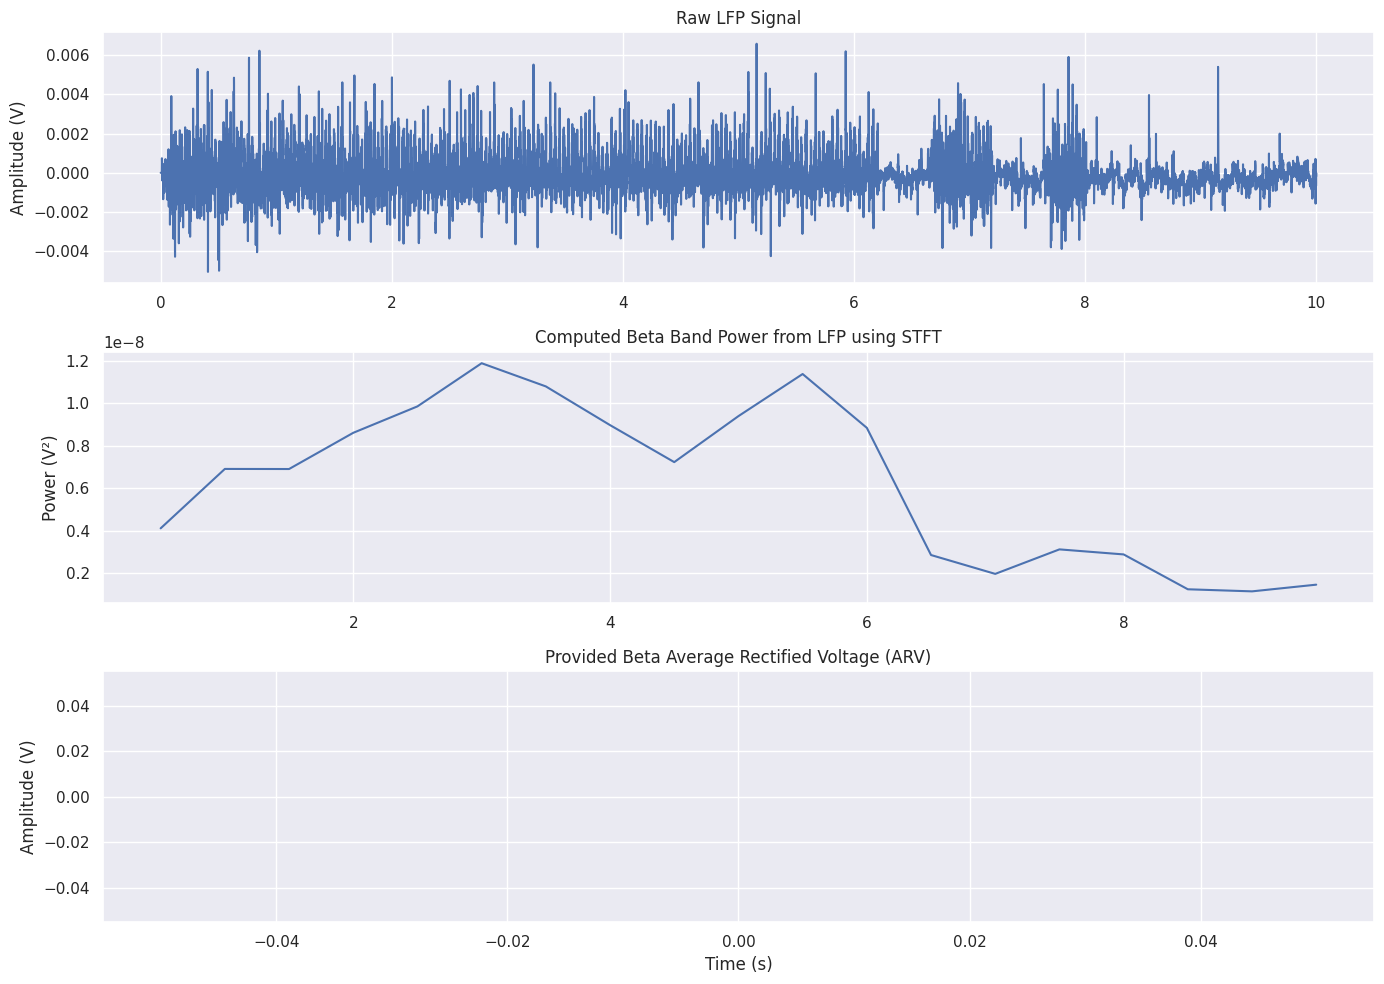

In [11]:
# Define the beta frequency band
beta_low = 13  # Hz
beta_high = 30  # Hz

# Function to calculate beta power over time
def calculate_beta_power(signal_data, fs, window_size=1.0, overlap=0.5):
    """
    Calculate beta power over time using spectrogram.
    
    Parameters:
    - signal_data: Input signal
    - fs: Sampling frequency
    - window_size: Size of window in seconds
    - overlap: Fraction of overlap between windows
    
    Returns:
    - times: Time points
    - beta_power: Power in beta band
    """
    nperseg = int(window_size * fs)
    noverlap = int(overlap * nperseg)
    
    # Calculate spectrogram
    f, t, Sxx = signal.spectrogram(signal_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    
    # Find indices of beta band in frequency array
    beta_idx = np.logical_and(f >= beta_low, f <= beta_high)
    
    # Calculate power in beta band for each time point
    beta_power = np.mean(Sxx[beta_idx, :], axis=0)
    
    return t, beta_power

# Calculate beta power from LFP data
# Use a shorter segment (10 seconds) to reduce computation time
analysis_time = 10  # seconds
samples_to_analyze = int(analysis_time * lfp_series.rate)
lfp_data_to_analyze = lfp_series.data[:samples_to_analyze]

# Calculate beta power
stft_times, stft_beta_power = calculate_beta_power(lfp_data_to_analyze, lfp_series.rate)

# Plot
plt.figure(figsize=(14, 10))

# Plot 1: Raw LFP signal
plt.subplot(3, 1, 1)
t_lfp = np.arange(len(lfp_data_to_analyze)) / lfp_series.rate
plt.plot(t_lfp, lfp_data_to_analyze)
plt.title('Raw LFP Signal')
plt.ylabel('Amplitude (V)')
plt.grid(True)

# Plot 2: Computed Beta Power from STFT
plt.subplot(3, 1, 2)
plt.plot(stft_times, stft_beta_power)
plt.title('Computed Beta Band Power from LFP using STFT')
plt.ylabel('Power (V²)')
plt.grid(True)

# Plot 3: Provided Beta ARV signal
plt.subplot(3, 1, 3)
# Take the subset of Beta ARV data that fits within our analysis time
beta_subset_mask = beta_times <= analysis_time
plt.plot(beta_times[beta_subset_mask], beta_data[beta_subset_mask])
plt.title('Provided Beta Average Rectified Voltage (ARV)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.grid(True)

plt.tight_layout()
plt.show()

The plots above show:

1. The raw LFP signal
2. The beta band power computed from the LFP signal using STFT
3. The provided Beta ARV from the dataset

While not identical (because the exact method used to calculate the Beta ARV in the dataset might differ), both the computed beta power and provided Beta ARV represent the power in the beta frequency band over time.

## Investigating Several Electrodes

Let's analyze the LFP data from multiple electrodes to see how the signals vary:

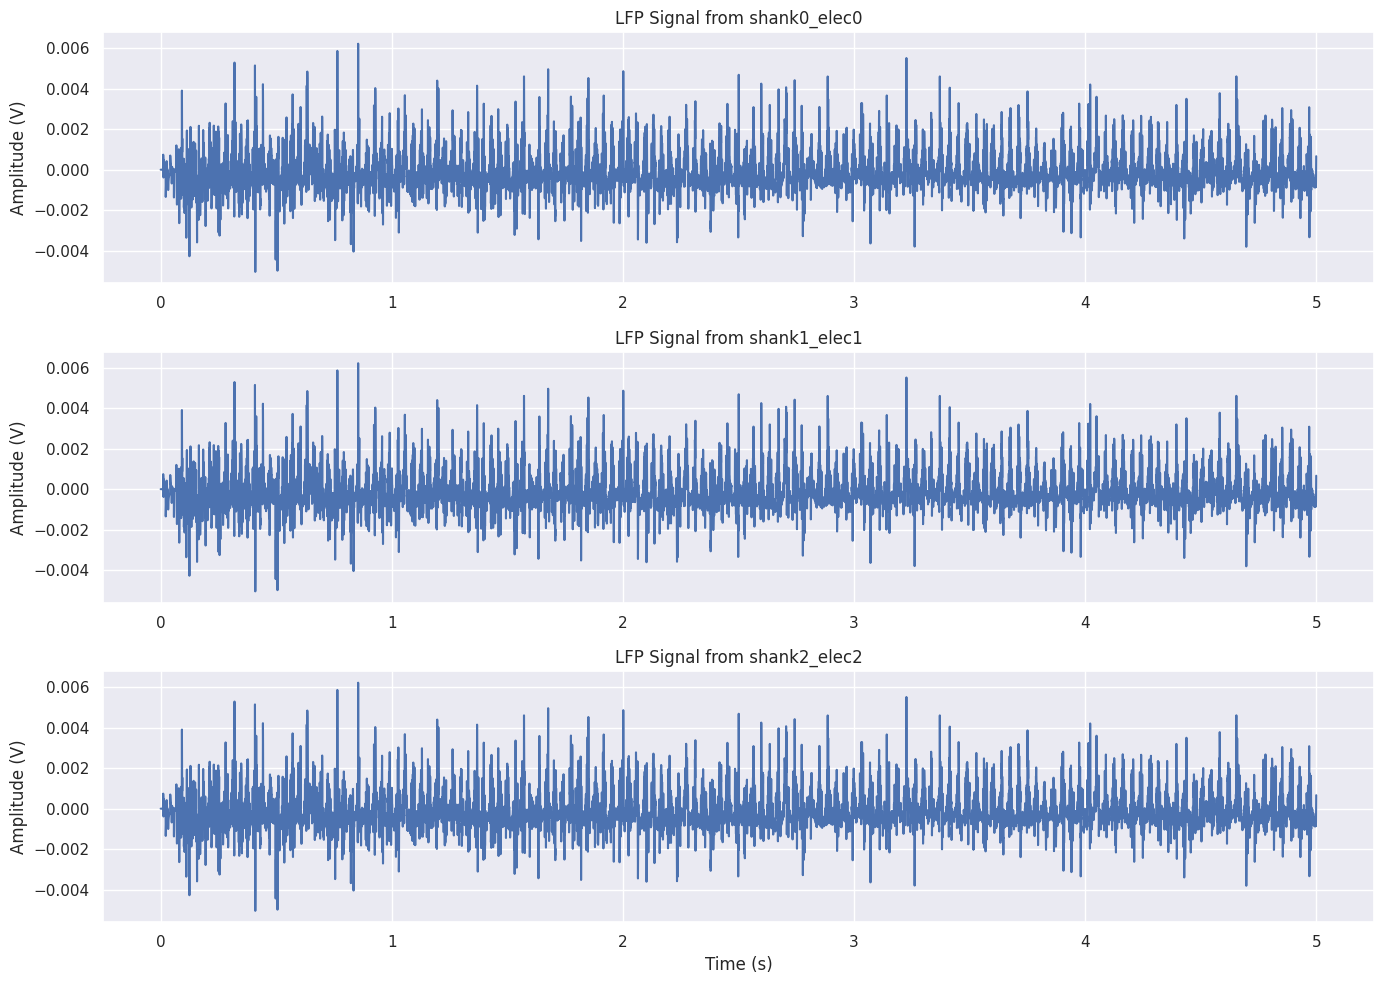

In [12]:
# First, let's extract the electrode information
electrode_info = beta_nwb.electrodes.to_dataframe()

# Select a subset of electrodes to analyze (3 electrodes from different shanks)
selected_electrodes = [0, 4, 8]  # One from each of three shanks
electrode_labels = electrode_info.loc[selected_electrodes, 'label'].values

# Extract a segment of LFP data for each electrode (first 5 seconds)
seconds_to_plot = 5
samples_to_plot = int(seconds_to_plot * lfp_series.rate)
lfp_data_subset = lfp_series.data[:samples_to_plot]

# Create time array
time = np.arange(samples_to_plot) / lfp_series.rate

# Plot the LFP data for each selected electrode
plt.figure(figsize=(14, 10))
for i, electrode_idx in enumerate(selected_electrodes):
    plt.subplot(len(selected_electrodes), 1, i+1)
    plt.plot(time, lfp_data_subset)
    plt.title(f'LFP Signal from {electrode_labels[i]}')
    plt.ylabel('Amplitude (V)')
    plt.grid(True)
    
    if i == len(selected_electrodes) - 1:
        plt.xlabel('Time (s)')
    
plt.tight_layout()
plt.show()

## Time-Frequency Analysis

Let's perform a time-frequency analysis of the LFP data to see how frequency content changes over time:

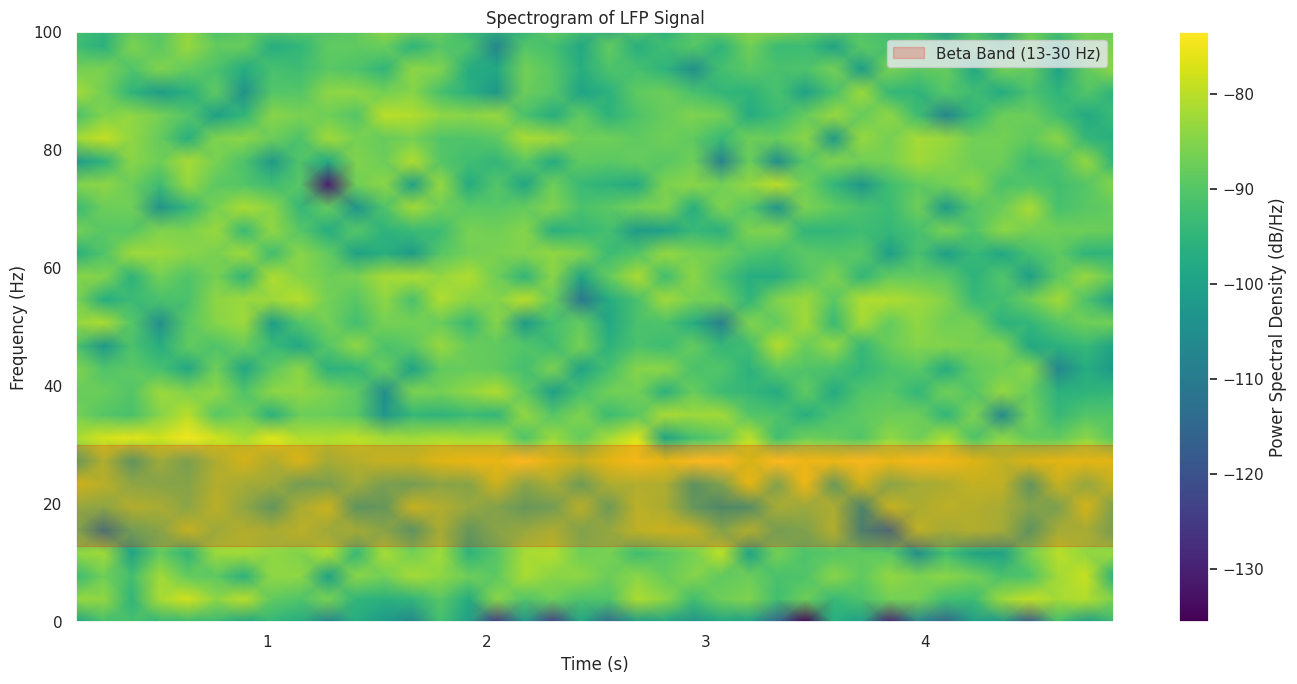

In [13]:
# Calculate spectrogram for a shorter segment (5 seconds) of LFP data to reduce computation
seconds_to_analyze = 5
samples_to_analyze = int(seconds_to_analyze * lfp_series.rate)
lfp_data_to_analyze = lfp_series.data[:samples_to_analyze]

# Calculate spectrogram with parameters optimized for speed
f, t, Sxx = signal.spectrogram(lfp_data_to_analyze, fs=lfp_series.rate, 
                              nperseg=512, noverlap=256, scaling='density')

# Plot the spectrogram
plt.figure(figsize=(14, 7))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
plt.title('Spectrogram of LFP Signal')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.colorbar(label='Power Spectral Density (dB/Hz)')
plt.ylim(0, 100)  # Limit y-axis to 0-100 Hz for better visualization

# Highlight the beta band (13-30 Hz)
plt.axhspan(13, 30, color='red', alpha=0.2, label='Beta Band (13-30 Hz)')
plt.legend()

plt.tight_layout()
plt.show()

## Examining Parkinsonian vs. Healthy Data

Parkinsonian brains typically show increased power in the beta frequency band (13-30 Hz) compared to healthy brains. Let's compare the power spectra of healthy simulated data with parkinsonian data.

First, let's check if we have parkinsonian data in the assets list:

In [14]:
# Search for parkinsonian data in our assets list
print("Searching for Parkinsonian data in assets...")
count = 0
parkinsonian_assets = []
for asset in dandiset.get_assets():
    if "parkinsonian" in asset.path.lower():
        parkinsonian_assets.append(f"- {asset.path} (ID: {asset.identifier})")
        count += 1
    if count >= 5:  # Limit to first 5 matches to avoid excessive output
        break

if parkinsonian_assets:
    for asset in parkinsonian_assets:
        print(asset)
else:
    print("No parkinsonian data found in the first set of assets. The full dataset may contain additional files.")

Searching for Parkinsonian data in assets...
No parkinsonian data found in the first set of assets. The full dataset may contain additional files.


Let's compare the beta band power in our healthy data:

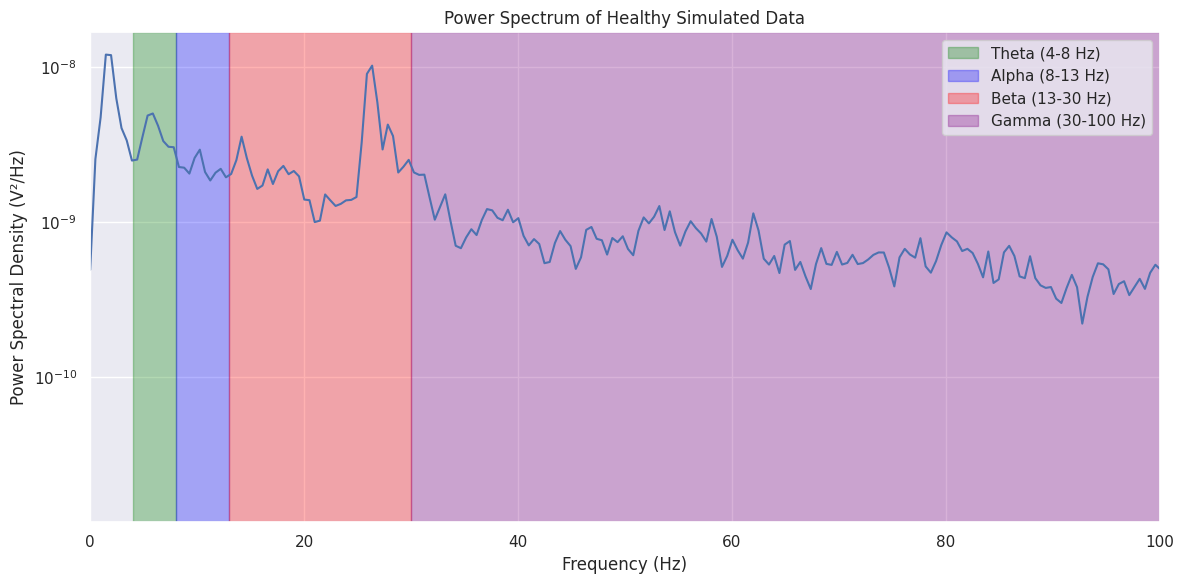

In [15]:
# Calculate the power spectrum for the LFP data
freq, psd_healthy = signal.welch(lfp_series.data[:], fs=lfp_series.rate, nperseg=4096)

# Plot the power spectrum with focus on beta band
plt.figure(figsize=(12, 6))
plt.semilogy(freq, psd_healthy)
plt.title('Power Spectrum of Healthy Simulated Data')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')

# Highlight frequency bands
plt.axvspan(4, 8, alpha=0.3, color='green', label='Theta (4-8 Hz)')
plt.axvspan(8, 13, alpha=0.3, color='blue', label='Alpha (8-13 Hz)')
plt.axvspan(13, 30, alpha=0.3, color='red', label='Beta (13-30 Hz)')
plt.axvspan(30, 100, alpha=0.3, color='purple', label='Gamma (30-100 Hz)')

plt.legend()
plt.grid(True)
plt.xlim(0, 100)  # Limit x-axis to 0-100 Hz for better visualization
plt.tight_layout()
plt.show()

The power spectrum shows the frequency content of the LFP signal from our healthy simulated data. In the context of Parkinson's disease, the beta band (13-30 Hz, highlighted in red) would typically show elevated power in parkinsonian subjects compared to healthy subjects.

The dataset contains both healthy and parkinsonian subjects, allowing researchers to compare these differences for biomarker development and understanding the pathophysiology of Parkinson's disease.

## Summary and Future Directions

In this notebook, we've explored the Parkinson's Electrophysiological Signal Dataset (PESD), which contains electrophysiological signals from both healthy and parkinsonian subjects. We've:

1. Loaded and examined NWB files containing LFP and Beta ARV data
2. Visualized the time series data from multiple electrodes
3. Performed frequency analysis to identify key spectral components
4. Compared the relationship between LFP signals and derived Beta ARV
5. Explored time-frequency analysis using spectrograms

### Key Findings

- The dataset contains both time-domain (LFP) and frequency-domain (Beta ARV) data
- The data is organized by subject type (healthy vs. parkinsonian) and signal type (LFP vs. Beta)
- The Beta frequency band (13-30 Hz) is of particular interest as a biomarker for Parkinson's disease

### Future Directions

This dataset opens up several possibilities for future analysis:

1. **Comparative Analysis**: Directly compare healthy vs. parkinsonian data to identify distinguishing features

2. **Feature Extraction**: Develop algorithms to extract meaningful features from LFP signals that correlate with disease state

3. **Biomarker Development**: Create robust biomarkers based on beta oscillations for disease monitoring

4. **Closed-Loop DBS Algorithm Development**: Use the dataset to design and test closed-loop deep brain stimulation algorithms that could respond to changes in beta power

5. **Machine Learning Applications**: Train models to classify or predict disease state based on electrophysiological signals

6. **Correlation Analysis**: Investigate the relationship between beta power and other frequency bands

7. **Temporal Dynamics**: Study the temporal dynamics of beta oscillations and their variability over time

## Acknowledgements

This notebook explores the Parkinson's Electrophysiological Signal Dataset (PESD) contributed by Ananna Biswas. For more details, refer to the related publication: [https://arxiv.org/abs/2407.17756](https://arxiv.org/abs/2407.17756).